# Assignemnent for Udacity Data Scientist Nanodegree: Chocolate Bar Ratings

We will first import all packages and read the file we are going to work with. For this assignment, I've selected Chocolate Bar Ratings dataset from kaggle.  

In [60]:
import pandas as pd
import numpy as np
import country_converter as coco

df = pd.read_csv("flavors_of_cacao.csv")

## Motivation

The Chocolate Bar Ratings dataset includes ratings for different chocolate bars, together with more detailed information on tested chocolates, such as manufracturer or origin of specific bean. In this analysis, we would like to get preliminary idea what makes the best chocolate. We want to infere if the rating depends on some of the characteristics related to production of chocolate. For example, we are interested if the rating of chocolates depends on  origin of chocolate bean or percentage of cocoa. This could be a starting point for further analysis and collection of more specific data on chocolate production.

## Data processing

We can have an initial look on the dataset.  

In [61]:
print("The dataset has {} observations and {} variables.".format(df.shape[0],df.shape[1]))
df.head()

The dataset has 1795 observations and 9 variables.


,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


We will first preprocess column names because they have additional lines, which can be confusing when we will be calling the  column names later on. We will process them to a single line and remove all white spaces.

In [62]:
#Remove all spaces and lines from the column names. 

tmp_cols = [i.replace('\n',' ') for i in df.columns] 
tmp_cols[0] = tmp_cols[0].replace(u'\xa0', u' ')
tmp_cols = [i.replace(' ','') for i in tmp_cols] 
df.columns = tmp_cols

Some of the countries names are misplelled or don't have uniform name in columns CompanyLocation and 
BroadBeanOrigin. We will try to clean this at least a bit using country_converter package.  

In [63]:
#Manually correct all obvious mistakes in country spelling. 

df = df.replace("Domincan Republic","Dominican Republic")
df = df.replace("Hawaii","United States")
df = df.replace("Cost Rica, Ven","Costa Rica, Venezuela")
df = df.replace("Niacragua","Nicaragua")
df = df.replace("Eucador","Ecuador")
df = df.replace("Mad., Java, PNG","Madagascar, Java, Papua New Guinea")
df = df.replace(r'^Ven\,',"Venezuela", regex=True)
df = df.replace("Amsterdam","Netherlands")
df = df.replace("Scotland","United Kingdom")
df = df.replace("Wales","United Kingdom")

#Apply country_convert to convert all "non-standardized" country names if possible.

cleaned_country_names = coco.convert(names = list(df["BroadBeanOrigin"]), to = 'name_short')
df["BroadBeanOrigin"] = cleaned_country_names

cleaned_country_names = coco.convert(names = list(df["CompanyLocation"]), to = 'name_short')
df["CompanyLocation"] = cleaned_country_names

We can also generate information about continents for the dataset with country_converter. This could be handy later on.

In [64]:
#Generate continents for the given country name.
continent = coco.convert(names = list(df["BroadBeanOrigin"]), to = 'continent')

#For the sake of bravity, when there is multiple continents per entry, keep only the first one. 
#This is not the best practice, but there are only few entries with different continents, so this should not affect
#the result substantially

for i in range(len(continent)):
    if type(continent[i]) == list:
        continent[i] = list(set(continent[i]))[0]       

df["ContinentBeanOrigin"] = continent

Some of the processed names which have more than two entities are converted to lists by country converter. We will take care by converting them to string and using regular expression to remove excessive characters. 

In [65]:
df["BroadBeanOrigin"] = df.BroadBeanOrigin.astype(str).str.replace('\[|\]|\'', '')

Furthermore, we can see that there are some blank cells (e.g in BeanType) or cells "not found" (e.g in BroadBeanOrigin). We will replace them with NaNs.  

In [66]:
df = df.replace(r'^\s*$', np.nan, regex = True)

df = df.replace(r'^not found$', np.nan, regex = True)


Columns BeanType, BroadBeanOrigin, and ContinentBeanOrigin have missing values. We can check percentage of NaNs in each column: 

In [67]:
df.isna().mean(axis = 0)

Company(Maker-ifknown)         0.000000
SpecificBeanOriginorBarName    0.000000
REF                            0.000000
ReviewDate                     0.000000
CocoaPercent                   0.000000
CompanyLocation                0.000000
Rating                         0.000000
BeanType                       0.494708
BroadBeanOrigin                0.054596
ContinentBeanOrigin            0.054596
dtype: float64

We will keep the rows with missing values for now, since we can still make descriptive analysis with other variables from the same observation. If we would use machine learning on the data we would need to handle this properly.

We also notice that CocoaPercent is storing strings. It is more convenient to convert them to floats. 

In [68]:
df.dtypes

df["CocoaPercent"] = df["CocoaPercent"].str.strip("%").astype('float') / 100

Now when we finally prepared the dataset, we can focus on specific questions related to the dataset. 

## Question 1: Which chocolates have the highest rating?

First, we are interested in chocolates with highest rating - we can see that two chocolates from the Italian company Amedei have the perfect 5.0 rating. 

In [69]:
df.sort_values("Rating",ascending = False).head()

,Company(Maker-ifknown),SpecificBeanOriginorBarName,REF,ReviewDate,CocoaPercent,CompanyLocation,Rating,BeanType,BroadBeanOrigin,ContinentBeanOrigin
78,Amedei,Chuao,111,2007,0.70,Italy,5.0,Trinitario,Venezuela,America
86,Amedei,Toscano Black,40,2006,0.70,Italy,5.0,Blend,NaN,NaN
222,Bonnat,Kaori,1339,2014,0.75,France,4.0,NaN,Brazil,America
76,Amedei,Porcelana,111,2007,0.70,Italy,4.0,Criollo (Porcelana),Venezuela,America
1663,Tobago Estate (Pralus),"Roxborough, Tobago",895,2012,0.70,France,4.0,Trinitario,Trinidad and Tobago,America


We see that the among the five highest rated chocolates, company location is either Italy or France. How does the prevalence of countries look for the best rated chocolates?

## Question 2: Which countries produce the best chocolate?

We will first define a function for plotting the frequency barplots. 

In [ ]:
def choco_barplot (data_frame, column, absolute_value = True, rating_treshold=4.0):
    '''
    Plots the frequency barplots of specified attributes for the best rated chocolates  .

            Parameters:
                    data_frame (pandas.DataFrame): Data frame used for the analysis 
                    column (string): Column for which freqency barplots will be generated
                    absolute_value (boolean): If relative or absolute frequency will be displayed
                    rating_treshold (float): Treshold for chocolate ratings
            Returns:
                    None

    '''
    
    tmp = df[df["Rating"] >= rating_treshold][column]
    
    tmp = tmp.str.split(", ").apply(pd.Series,1).stack()
    best_count = tmp.value_counts()
    
    if absolute_value == True:
        overall_counts = 1
    else:
        overall_counts = df[column].value_counts()[best_count.keys()]
    (best_count/overall_counts).plot.barh()
    
    

Here we display simple barplot with frequency of countries where the companies which produce the best chocolate are from.

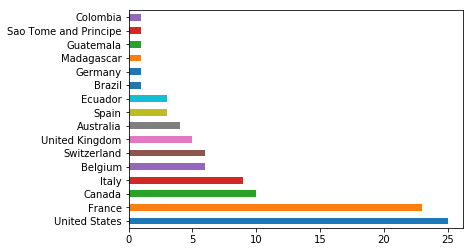

In [70]:
choco_barplot(df,"CompanyLocation")

I never thought of USA as the land of the best chocolate. What if normalize the counts to the overall number of tested chocolates from the specific country?

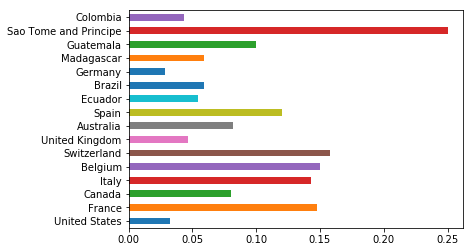

In [71]:
choco_barplot(df,"CompanyLocation",absolute_value=False)

## Question 3: Where does the cocoa bean from best chocolates come from?

Similarly, I am intersted if the origin of cocoa bean has something to do with the taste of chocolate? We will look at the barplot. 

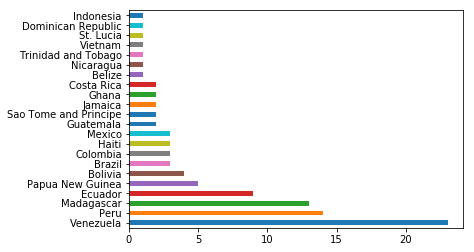

In [72]:
choco_barplot(df,"BroadBeanOrigin")

This plot indicates that Venezuela has the best chocolate beans. However, Venezuela also has the highest number of chocolate beans production overall, so I am not sure if we can say that Venezuela has the best chocolate beans. 

We can now look the same thing across the continents.


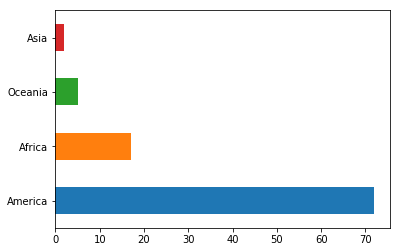

In [73]:
choco_barplot(df,"ContinentBeanOrigin")

From the above barplot, we can see that the chocolate beans from the best chocolates come majorly from America (South America).

## Question 4: Do beans grown on different continents yield different amount of chocolate?

We will check the distributions of cocoa percentages across beans grown in different continents.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A4EC7DEDD8>,
      dtype=object)

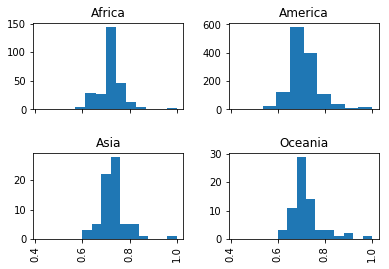

In [74]:
df.CocoaPercent.hist(by =df["ContinentBeanOrigin"],sharex = True)

It does not seem that there is significant distribution of chocolate percentage in chocolate from beans across different continents.

## Question 5: Does the Cocoa Percent influence the rating?

Finally, we can make simple plots to explore if Cocoa percent influences the Chocolate Rating. It would be really easy for chocolate producers if there is a clear relationship.

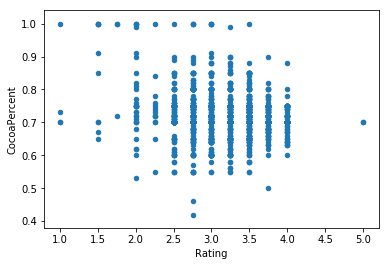

In [75]:
df[["Rating","CocoaPercent"]].plot.scatter("Rating","CocoaPercent")

## Bonus question: Can we predict the chocolate rating using other variables in the dataset?

Unforunatelly, there does not seem to be enough information to develop predictive models to predict rating of chocolate using other variables. However, we learnt something new today using simple descriptive analysis :-)

## Short Recap

Chocolate rating does not seem to be influenced by either cocoa percentage nor location of cocoa bean planting site. It seems that European countries make the best chocolate bars. However, to understand what really influences quality of chocolate we would need additional data such as detailed information on e.g. cocoa beans growing conditions, or specific production steps.     